In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk

In [59]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
data= pd.read_csv("https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv",encoding="latin1")
data

In [ ]:
print(data.isnull().sum())

In [54]:
data = data.fillna(method='ffill')
data.head()
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)
tags = list(set(data['Tag'].values))
num_tags = len(tags)

<ipython-input-54-17387dc9a6a6>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [56]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]
getter = SentanceGetter(data)
sentances = getter.sentances


<ipython-input-56-17381932779b>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [57]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [60]:
max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [61]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │       1,758,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,883,117 (7.18 MB)

 Trainable params: 1,883,117 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

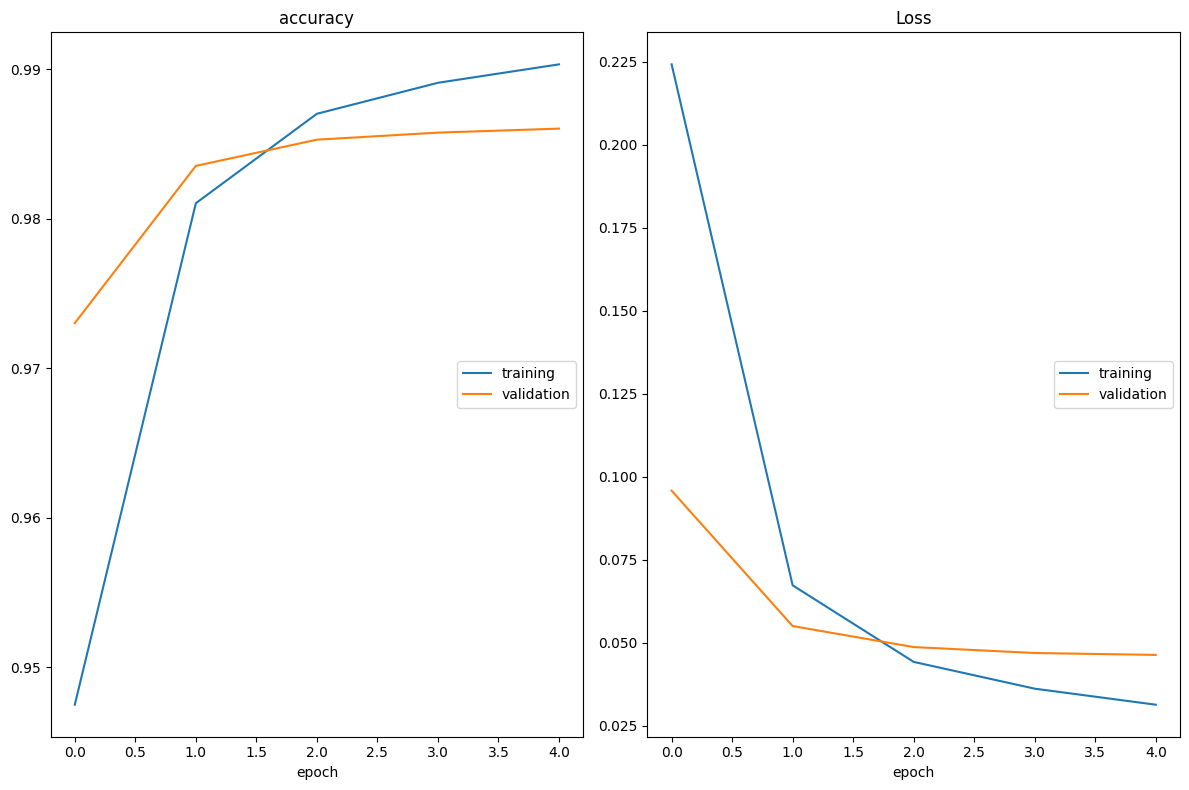

accuracy
	training         	 (min:    0.948, max:    0.990, cur:    0.990)
	validation       	 (min:    0.973, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.031, max:    0.224, cur:    0.031)
	validation       	 (min:    0.046, max:    0.096, cur:    0.046)
540/540 ━━━━━━━━━━━━━━━━━━━━ 129s 240ms/step - accuracy: 0.9904 - loss: 0.0313 - val_accuracy: 0.9860 - val_loss: 0.0464


In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

In [64]:
model.evaluate(x_test, np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9856 - loss: 0.0496


[0.047208186239004135, 0.9860510230064392]

In [65]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Word           True 	 Pred

------------------------------
The            O    	O
project        O    	O
,              O    	O
which          O    	O
began          O    	O
in             O    	O
2007           B-tim	B-tim
and            O    	O
could          O    	O
double         O    	O
the            O    	O
Canal          B-art	B-geo
's             O    	O
capacity       O    	O
,              O    	O
is             O    	O
expected       O    	O
to             O    	O
be             O    	O
completed      O    	O
in             O    	O
2014           B-tim	B-tim
-              I-tim	I-tim
15             I-tim	I-tim
.              O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown      O    	O
touchdown  